# Sistema de predicción de concentración de CO 

Este proyecto se enfoca en la predicción de la concentración de monóxido de carbono (CO) en áreas urbanas, empleando datos experimentales recogidos por una estación de medición del CICATA equipada con tecnología IoT.
El monóxido de carbono o CO, un gas peligroso, incoloro e inodoro, que resulta de la combustión incompleta de combustibles fósiles y constituye una amenaza significativa tanto para la salud humana como para la calidad del aire en entornos urbanos. Las principales fuentes de emisión de CO en las ciudades incluyen el tráfico vehicular y las actividades industriales, cuyas variaciones diarias y estacionales influyen de manera notable en la concentración atmosférica de este gas. Comprender y predecir con precisión estos niveles es vital para la toma de decisiones eficaces en salud pública y gestión ambiental.

La hipótesis central de este estudio postula que la concentración de CO en condiciones urbanas normales sigue un patrón temporal discernible. Este supuesto subraya la importancia de analizar las tendencias y los ciclos temporales en los niveles de CO, lo que podría revelar correlaciones significativas con variables como el tráfico, las condiciones meteorológicas, y las actividades humanas. Para investigar esta hipótesis, se utilizarán técnicas avanzadas de aprendizaje automático, con el objetivo de desarrollar un modelo predictivo que pueda identificar y aprender de los patrones en los datos recogidos.

En el experimento se recolectaron datos de la estación de medición concentración de CO durante 13 días consecutivos, registrando mediciones cada minuto. Esta recopilación de datos de alta frecuencia ofrece una visión granular de las fluctuaciones en los niveles de CO. Aunque el tiempo en días es reducido, la serie temportal por mínutos recopilada permite examinar las variaciones en la concentración de CO no solo en una escala diaria, sino también en intervalos más cortos, como horas pico de tráfico o cambios específicos relacionados con las actividades industriales y humanas. Esto es crucial para entender la dinámica del CO en un contexto urbano, donde los factores como la densidad del tráfico y las actividades industriales pueden cambiar rápidamente.

## Hipotesis
La cencentración de CO en condiciones normales sigue un patrón temporal 

## Limpieza de base de datos
Como esta base de datos es experimental puede contar con valores faltantes, valores atípicos etc., así que lo primero será limpiarla

Cargamos los datos y mostramos 5 filas para ver que contienen

In [3]:
import pandas as pd
data = pd.read_excel('data.xlsx')
data.head(5)


,Fecha,CO
0,2023-06-21 00:00:00,0.87
1,2023-06-21 00:01:00,0.92
2,2023-06-21 00:02:00,0.91
3,2023-06-21 00:03:00,0.79
4,2023-06-21 00:04:00,0.53


Como podemos observar son fechas con resolución de minutos y la concentración de CO respectiva. Ahora revisaremos su información

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18720 entries, 0 to 18719
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   18720 non-null  datetime64[ns]
 1   CO      18706 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 292.6 KB


Podemos ver que fecha es un formato datetime64 y Co es un flotante. Veamos si existen valores faltantes

In [5]:
data.isnull().sum()

Fecha     0
CO       14
dtype: int64

Podemos observar que hay algunos valores faltantes. Hay que revisar si existen valores atípicos(outliers)

CO - Estadísticas:
Mínimo: 0.21
Media: 0.81
Mediana: 0.80
Moda: 0.79
Máximo: 4.78



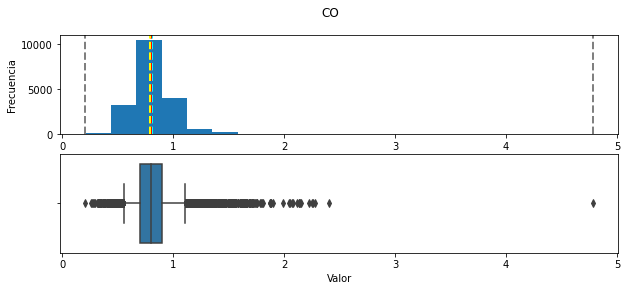

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_distribution(var_data):
    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]

    print(f"{var_data.name} - Estadísticas:\nMínimo: {min_val:.2f}\nMedia: {mean_val:.2f}\nMediana: {med_val:.2f}\nModa: {mod_val:.2f}\nMáximo: {max_val:.2f}\n")

    fig, ax = plt.subplots(2, 1, figsize=(10, 4))

    ax[0].hist(var_data, bins=20)
    ax[0].set_ylabel('Frecuencia')

    ax[0].axvline(x=min_val, color='gray', linestyle='dashed', linewidth=2)
    ax[0].axvline(x=mean_val, color='cyan', linestyle='dashed', linewidth=2)
    ax[0].axvline(x=med_val, color='red', linestyle='dashed', linewidth=2)
    ax[0].axvline(x=mod_val, color='yellow', linestyle='dashed', linewidth=2)
    ax[0].axvline(x=max_val, color='gray', linestyle='dashed', linewidth=2)

    sns.boxplot(x=var_data, ax=ax[1], whis=[5, 95])
    ax[1].set_xlabel('Valor')
   

    fig.suptitle(var_data.name)
    plt.show()

show_distribution(data['CO'])


Como podemos obervar hay valores atípicos que debemos manejar.Como criterio reemplazaremos los valores faltantes o con más de 7 desviaciones estandar por la media de los valores adyacentes existentes.

In [7]:
import pandas as pd
import numpy as np

def replace_outliers(data, column):
    mean = data[column].mean()
    std = data[column].std()

    outliers = (data[column].isna()) | (np.abs(data[column] - mean) > 7 * std)

    for index in data[outliers].index:
        prev_index = next((i for i in range(index - 1, -1, -1) if not outliers.iloc[i]), None)
        next_index = next((i for i in range(index + 1, len(data)) if not outliers.iloc[i]), None)

        if prev_index is not None and next_index is not None:
            data.at[index, column] = (data[column].iloc[prev_index] + data[column].iloc[next_index]) / 2
        elif prev_index is not None:
            data.at[index, column] = data[column].iloc[prev_index]
        elif next_index is not None:
            data.at[index, column] = data[column].iloc[next_index]
        else:
            data.at[index, column] = mean

replace_outliers(data, 'CO')



Corroboramos que los datos ahora están limpios y los normalizaremos

In [8]:
data.isnull().sum()

Fecha    0
CO       0
dtype: int64

0    0.352941
1    0.379679
2    0.374332
3    0.310160
4    0.171123
Name: CO_normalized, dtype: float64
CO_normalized - Estadísticas:
Mínimo: 0.00
Media: 0.32
Mediana: 0.32
Moda: 0.31
Máximo: 1.00



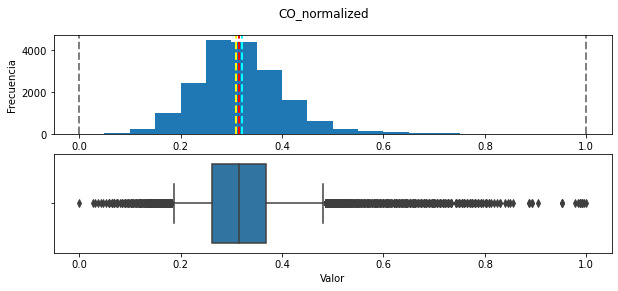

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

co_values = data['CO'].values.reshape(-1, 1)
data['CO_normalized'] = scaler.fit_transform(co_values)

print(data['CO_normalized'].head())

show_distribution(data['CO_normalized'])

La información se ve mucho mejor, aún existen valores alejados de pero estan dentro de lo esperado

Ahora nos aseguraremos que las fechas están en orden cronológico. 

In [10]:
is_chronological = data['Fecha'].is_monotonic_increasing
is_chronological


True

Como vemos, están en orden cronológico.


## Visualización de los datos
Veamos el comportamiento por día de la concentración de CO

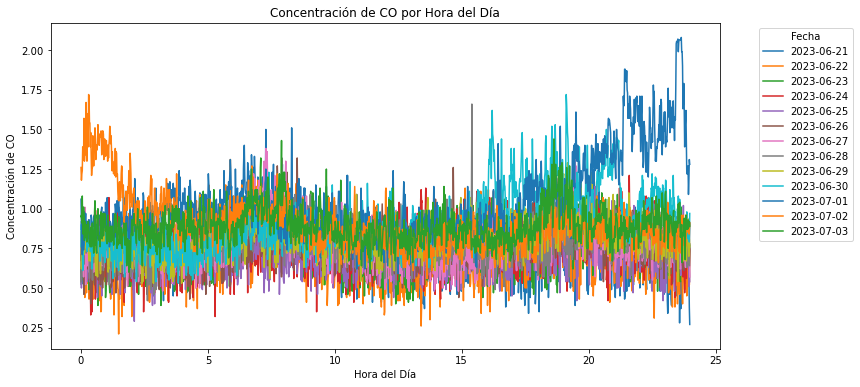

In [11]:
import matplotlib.pyplot as plt

data['Hora'] = data['Fecha'].dt.hour + data['Fecha'].dt.minute / 60

grouped_data = data.groupby(data['Fecha'].dt.date)

plt.figure(figsize=(12, 6))
for date, group in grouped_data:
    plt.plot(group['Hora'], group['CO'], label=str(date))

plt.title('Concentración de CO por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Concentración de CO')
plt.legend(title='Fecha', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Veamos la frecuencia de los valores y el rango de la desviación estandar.

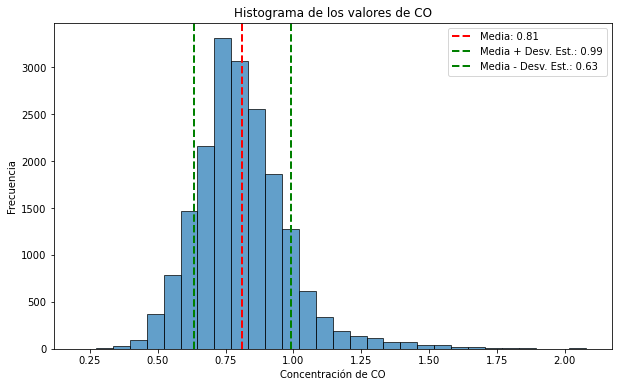

In [12]:
mean_co = data['CO'].mean()
std_co = data['CO'].std()

plt.figure(figsize=(10, 6))
plt.hist(data['CO'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Histograma de los valores de CO')
plt.xlabel('Concentración de CO')
plt.ylabel('Frecuencia')

plt.axvline(mean_co, color='red', linestyle='dashed', linewidth=2, label=f'Media: {mean_co:.2f}')
plt.axvline(mean_co + std_co, color='green', linestyle='dashed', linewidth=2, label=f'Media + Desv. Est.: {mean_co + std_co:.2f}')
plt.axvline(mean_co - std_co, color='green', linestyle='dashed', linewidth=2, label=f'Media - Desv. Est.: {mean_co - std_co:.2f}')

plt.legend()

plt.show()


Parece que la concentración de CO tiene un comportamiento Gaussiano

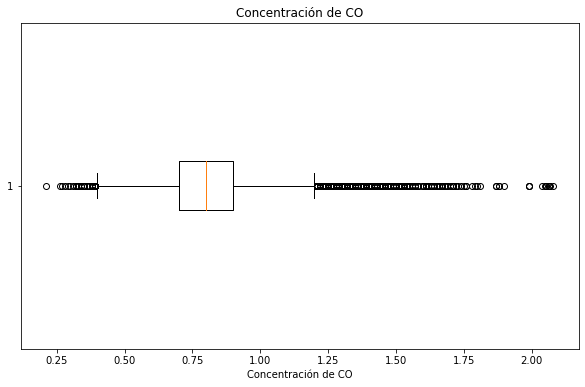

In [13]:
plt.figure(figsize=(10, 6))
plt.boxplot(data['CO'], vert=False)
plt.title('Concentración de CO')
plt.xlabel('Concentración de CO')
plt.show()


## Entrenamiento de modelos

### Separación de los datos
Separaremos el conjunto de entrenamiento y el de prueba utilizaremos 70% para entrenar y 30% para validar

In [14]:
from sklearn.model_selection import train_test_split
data['Fecha'] = pd.to_datetime(data['Fecha'])
data['Year'] = data['Fecha'].dt.year
data['Month'] = data['Fecha'].dt.month
data['Day'] = data['Fecha'].dt.day
data['Hour'] = data['Fecha'].dt.hour
data['Minute_of_Day'] = data['Fecha'].dt.hour * 60 + data['Fecha'].dt.minute

X = data[['Year', 'Month', 'Day', 'Hour', 'Minute_of_Day']]
y = data['CO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Conjunto de Entrenamiento:', X_train.shape[0], 'muestras')
print('Conjunto de Validación:', X_test.shape[0], 'muestras')


Conjunto de Entrenamiento: 13104 muestras
Conjunto de Validación: 5616 muestras


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import math

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)





LinearRegression()

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [17]:
from sklearn.svm import SVR

svm_reg = SVR()
svm_reg.fit(X_train, y_train)

SVR()

In [18]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(X_train, y_train)

/opt/anaconda/envs/main/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda/envs/main/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=24,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Resultados de los modelos
Utilizaremos los criterios de MSE, RMSE y R cuadrada para evaluar los modelos

### resultados de regresión lineal

Error cuadrático medio (MSE): 0.02523427691422828
Raíz del error cuadrático medio (RMSE): 0.15885300410828962
Coeficiente de determinación (R²): 0.23317200088220147


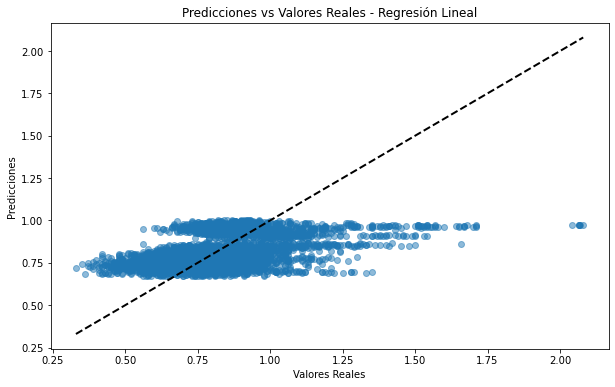

In [19]:
lin_reg_pred = lin_reg.predict(X_test)
lin_reg_mse = mean_squared_error(y_test, lin_reg_pred)
lin_reg_rmse = math.sqrt(lin_reg_mse)
lin_reg_r2 = r2_score(y_test, lin_reg_pred)

print("Error cuadrático medio (MSE):", lin_reg_mse)
print("Raíz del error cuadrático medio (RMSE):", lin_reg_rmse)
print("Coeficiente de determinación (R²):", lin_reg_r2)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, lin_reg_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales - Regresión Lineal')
plt.show()

### Resultados de Random Forest

Error cuadrático medio (MSE): 0.011077996143162393
Raíz del error cuadrático medio (RMSE): 0.10525206004236873
Coeficiente de determinación (R²): 0.6633579933528402


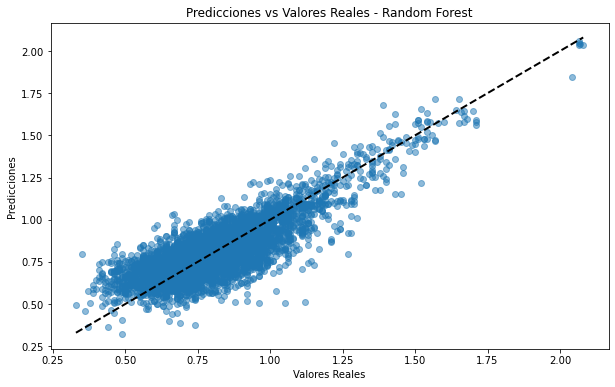

In [20]:
rf_pred = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = math.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_pred)

print("Error cuadrático medio (MSE):", rf_mse)
print("Raíz del error cuadrático medio (RMSE):", rf_rmse)
print("Coeficiente de determinación (R²):", rf_r2)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales - Random Forest')
plt.show()

### Resultados de SVM

Error cuadrático medio (MSE): 0.028538468200057357
Raíz del error cuadrático medio (RMSE): 0.16893332471734923
Coeficiente de determinación (R²): 0.1327630848261947


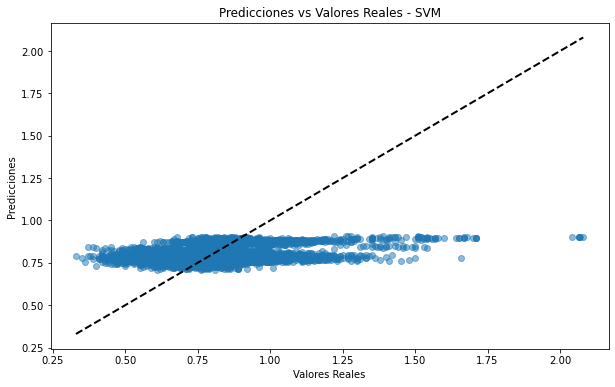

In [21]:
svm_reg_pred = svm_reg.predict(X_test)
svm_reg_mse = mean_squared_error(y_test, svm_reg_pred)
svm_reg_rmse = math.sqrt(svm_reg_mse)
svm_reg_r2 = r2_score(y_test, svm_reg_pred)

print("Error cuadrático medio (MSE):", svm_reg_mse)
print("Raíz del error cuadrático medio (RMSE):", svm_reg_rmse)
print("Coeficiente de determinación (R²):", svm_reg_r2)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, svm_reg_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales - SVM')
plt.show()

### Resultados de XGBoost

Error cuadrático medio (MSE): 0.01100920607416125
Raíz del error cuadrático medio (RMSE): 0.10492476387469857
Coeficiente de determinación (R²): 0.665448409937814


/opt/anaconda/envs/main/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


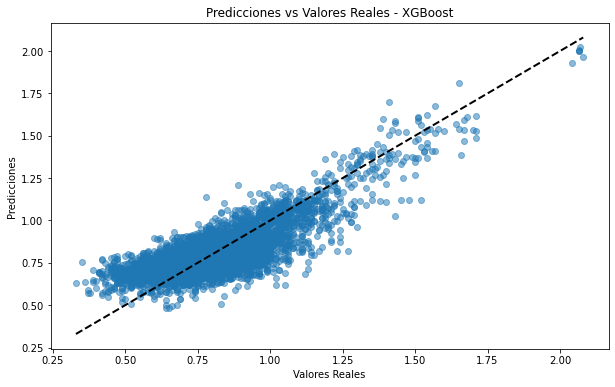

In [22]:
xg_reg_pred = xg_reg.predict(X_test)

xg_reg_mse = mean_squared_error(y_test, xg_reg_pred)
xg_reg_rmse = math.sqrt(xg_reg_mse)
xg_reg_r2 = r2_score(y_test, xg_reg_pred)

print("Error cuadrático medio (MSE):", xg_reg_mse)
print("Raíz del error cuadrático medio (RMSE):", xg_reg_rmse)
print("Coeficiente de determinación (R²):", xg_reg_r2)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, xg_reg_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales - XGBoost')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

xg_reg = XGBRegressor(objective='reg:squarederror')

parameters = {
    'max_depth': [3, 5],  # Profundidades más comunes
    'learning_rate': [0.01, 0.1],  # Tasa de aprendizaje inicial y un valor estándar
    'n_estimators': [100, 200],  # Número de árboles
    'subsample': [0.8, 1]  # Submuestreo de los datos de entrenamiento
}

grid_search = GridSearchCV(estimator=xg_reg, param_grid=parameters, cv=3, n_jobs=-1, verbose=1, scoring='r2')
grid_search.fit(X_train, y_train)

best_xg_reg = grid_search.best_estimator_

xg_reg_pred = best_xg_reg.predict(X_test)

xg_reg_r2 = r2_score(y_test, xg_reg_pred)
print("Coeficiente de determinación (R²) después del ajuste:", xg_reg_r2)


Coeficiente de determinación despues del ajuste: 0.66250260612482

Como observamos no mejora mucho el desempeño del modelo incluso optimizando los hiperparametros

# Conclusiones

Un valor de \( R^2 \) de 0.66 en el proyecto de predicción de la concentración de monóxido de carbono (CO) indica que el modelo es capaz de explicar aproximadamente dos tercios de la variabilidad en los datos, lo cual es una medida medianamente buena de ajuste en muchos contextos, especialmente dada la complejidad de predecir la calidad del aire en entornos urbanos. Este resultado sugiere que mientras el modelo tiene una capacidad moderada para capturar la relación entre las variables independientes y la concentración de CO, todavía hay espacio para mejorar, ya sea ajustando las variables existentes, incorporando nuevas, o experimentando con diferentes algoritmos. Algunos de los puntos importantes para tomar en cuenta son que la muestra era pequeña en cuanto a días, aunque de alta resolución, lo que puede indicar que hacen falta datos para mejorar el modelo, además puede que existan más factores relevantes para tomar en cuenta en la concentración de CO y que no fueron tomadas en cuenta.